# Autoencoder para classificação
Com autoencoder também conseguimos fazer classificação, que nesse caso é conhecido como detecção de anomalia. A vantagem de se utilizar o autoencoder para essa tarefa é que podemos treinar com dados de uma única amostra, util em situações em que nosso sistema majoritariamente gera um unico tipo de amostra, por exemplo: peças boas em uma linha de produção. Tudo que diferir do padrão aprendido pelo autoencoder será considerado uma anomalia, dessa forma com o autoencoder teremos um modelo de classificação binária: Imagens dentro do padrão e imagens anomalas.

Vantagens:
* Por se tratar de autoencoder temos a caracteristica de treinamento não supervisionado o que implica que não precisamos classificar nossos dados, apenas coletar as amostras dentro do padrão esperado.
* Além de detectar imagens anomalas, com autoencoder podemos rastrear na imagem a região da imagem que gerou a anomalia

Desvantagens:
* Performance inferior em relação ao treinamento supervisionado
* Apenas funciona para classificação binária
* Modelos mais complexos com maior tempo de inferencia (Encoder + Decoder)
* Se usarmos autoencoder para classificação binária porque não temos amostras de outra classe, como validar e confiar o modelo para produção?

In [13]:
import cv2
import numpy as np
from imutils import paths
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from matplotlib import pyplot as plt
from tqdm import tqdm

## BatchGenerator
Para esse exemplo iremos utilizar um dataset que foi gerado durante a fase de desenvolvimento do MVP. Com o uso do BatchGenerator não iremos precisar carregar todas as imagens na memória e realizar nosso pre processamento em tempo de execução.

In [14]:
class BatchGenerator(Sequence):
    def __init__(self, path, batch_size, image_size=(28, 28), gray_scale=True):
        self._batch_size = batch_size
        self._images_path = list(paths.list_images(path))[:300]  # para fins de exemplo vamos utilziar apenas 300 imagens
        self._image_size = image_size
        self._gray_scale = gray_scale

    def __len__(self):
        return int(np.ceil(len(self._images_path) / self._batch_size))

    def __getitem__(self, idx):
        l_bound = idx * self._batch_size
        r_bound = (idx + 1) * self._batch_size

        if r_bound > len(self._images_path):
            r_bound = len(self._images_path)
            l_bound = r_bound - self._batch_size

        instance_count = 0
        x_batch = np.zeros((r_bound - l_bound, self._image_size[1], self._image_size[0], 1 if self._gray_scale else 3))

        for instance_count, train_instance in enumerate(self._images_path[l_bound:r_bound]):
            image = cv2.imread(train_instance)
            image = cv2.resize(image, self._image_size)
            if self._gray_scale:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = image[..., np.newaxis]
            image = image / 255
            x_batch[instance_count] = image

        return x_batch, x_batch

    def on_epoch_end(self):
        np.random.shuffle(self._images_path)

#### Instanciar os generator
generator para treino e validação

In [15]:
train_generator = BatchGenerator("./data/screw_dataset/train/wo_screw", 8)
val_generator = BatchGenerator("./data/screw_dataset/train/wo_screw", 8)

## Criação do autoencoder

In [16]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # output (4, 4, 8)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#### Callback para salvar os modelos com o melhor loss

In [17]:
MODEL_NAME = "anomaly_detector"
best_loss_model_name = f"{MODEL_NAME}_best_loss.h5"
check_point_saver_best_loss = ModelCheckpoint(best_loss_model_name, monitor='val_loss', verbose=1,
                                              save_best_only=True, save_weights_only=False, mode='auto',
                                              period=1)

###### Treino

In [18]:
autoencoder.fit(train_generator, validation_data=val_generator, epochs=200, callbacks=[check_point_saver_best_loss])

Epoch 1/200
38/38 [==============================] - ETA: 0s - loss: 0.6452
Epoch 1: val_loss improved from inf to 0.63009, saving model to anomaly_detector_best_loss.h5
38/38 [==============================] - 3s 46ms/step - loss: 0.6452 - val_loss: 0.6301
Epoch 2/200
36/38 [===========================>..] - ETA: 0s - loss: 0.6149
Epoch 2: val_loss improved from 0.63009 to 0.59595, saving model to anomaly_detector_best_loss.h5
38/38 [==============================] - 1s 37ms/step - loss: 0.6126 - val_loss: 0.5960
Epoch 3/200
38/38 [==============================] - ETA: 0s - loss: 0.5900
Epoch 3: val_loss improved from 0.59595 to 0.58572, saving model to anomaly_detector_best_loss.h5
38/38 [==============================] - 2s 48ms/step - loss: 0.5900 - val_loss: 0.5857
Epoch 4/200
37/38 [============================>.] - ETA: 0s - loss: 0.5845
Epoch 4: val_loss improved from 0.58572 to 0.58155, saving model to anomaly_detector_best_loss.h5
38/38 [==============================] - 2s 

# Validação

In [19]:
autoencoder = load_model(best_loss_model_name)

1/1 [==============================] - 0s 48ms/step


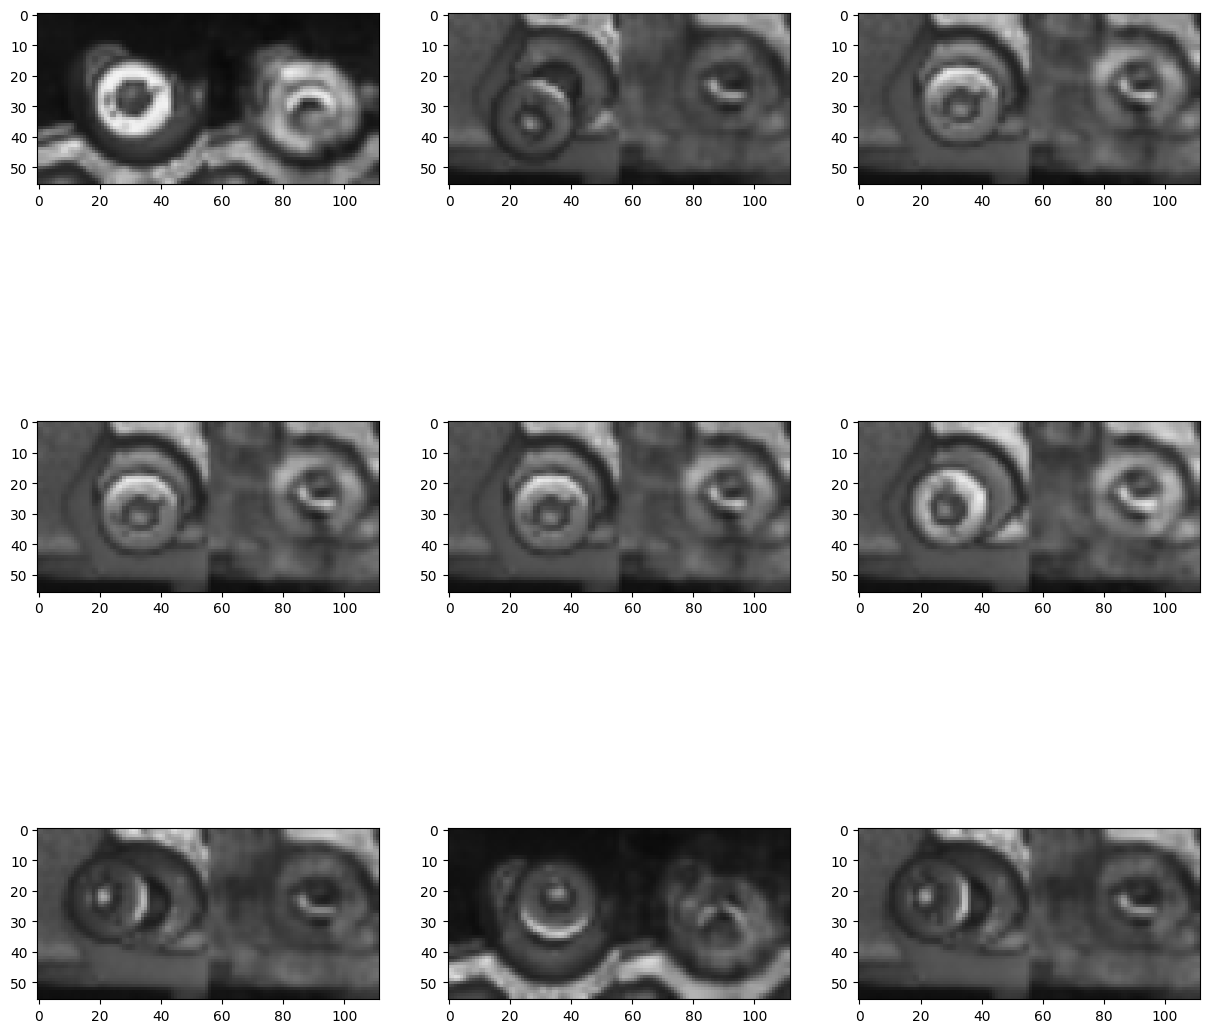

In [45]:
plt.figure(figsize=(15,15))
test_generator = BatchGenerator("./data/screw_dataset/val/allen/", 9)

# batch = next(test_generator)
batch = next(iter(test_generator))[0]

preds = autoencoder.predict(batch)
for i, (gt, pred) in enumerate(zip(batch, preds)):
    plt.subplot(3,3,i+1)
    
    gt = np.uint8(gt * 255)
    pred = np.uint8(pred * 255)
    concat = cv2.hconcat([gt, pred])
    concat = cv2.resize(concat, None, fx=2, fy=2)
    plt.imshow(cv2.cvtColor(concat, cv2.COLOR_GRAY2RGB))
plt.show()

## Exercicio
Observe a geração de imagens pelo autoencoder em imagens que estão fora do padrão (imagens com parafusos), como ficou as imagens geradas?

Compare as imagens de entrada vs de saída e crie uma métrica para classificar as anomalias

In [47]:
def calc_mse(generator):
    mse = []
    for sample, _ in tqdm(generator):
        pred = autoencoder.predict(sample)

        se = pred - sample
        se = se ** 2
        se = se.sum()
        mse.append(se)
    mse = np.asarray(mse)
    return mse.mean(), mse.std()

true_generator = BatchGenerator("./data/screw_dataset/val/wo_screw", 1)
anomaly_generator = BatchGenerator("./data/screw_dataset/val/torx", 1)
print(calc_mse(true_generator))
print(calc_mse(anomaly_generator))

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 2/300 [00:00<00:25, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 4/300 [00:00<00:23, 12.47it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 6/300 [00:00<00:22, 13.20it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 8/300 [00:00<00:21, 13.79it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 10/300 [00:00<00:20, 13.93it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 12/300 [00:00<00:20, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 14/300 [00:01<00:20, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 16/300 [00:01<00:20, 13.95it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 18/300 [00:01<00:20, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 20/300 [00:01<00:20, 13.62it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 22/300 [00:01<00:21, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 24/300 [00:01<00:20, 13.25it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 26/300 [00:01<00:22, 12.31it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 28/300 [00:02<00:23, 11.53it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 30/300 [00:02<00:23, 11.26it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 32/300 [00:02<00:25, 10.47it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 34/300 [00:02<00:25, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 36/300 [00:02<00:25, 10.55it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 38/300 [00:03<00:25, 10.44it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 40/300 [00:03<00:23, 11.26it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 42/300 [00:03<00:22, 11.65it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 44/300 [00:03<00:22, 11.44it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 46/300 [00:03<00:21, 11.80it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 48/300 [00:03<00:20, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 50/300 [00:04<00:20, 12.50it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 52/300 [00:04<00:20, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 54/300 [00:04<00:20, 12.05it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 56/300 [00:04<00:20, 12.01it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▉        | 58/300 [00:04<00:21, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 60/300 [00:05<00:21, 10.99it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 62/300 [00:05<00:21, 11.12it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 64/300 [00:05<00:20, 11.38it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 66/300 [00:05<00:19, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 68/300 [00:05<00:18, 12.69it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 70/300 [00:05<00:17, 13.10it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 72/300 [00:05<00:17, 13.22it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 74/300 [00:06<00:18, 12.46it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 76/300 [00:06<00:17, 12.93it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 78/300 [00:06<00:16, 13.39it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 80/300 [00:06<00:15, 13.76it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 82/300 [00:06<00:16, 12.89it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 84/300 [00:06<00:17, 12.23it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 86/300 [00:07<00:17, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 88/300 [00:07<00:17, 12.10it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 90/300 [00:07<00:16, 12.70it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 92/300 [00:07<00:16, 12.89it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 94/300 [00:07<00:15, 13.07it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 96/300 [00:07<00:17, 11.71it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 98/300 [00:08<00:16, 12.14it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 100/300 [00:08<00:15, 12.81it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 102/300 [00:08<00:15, 13.11it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 104/300 [00:08<00:15, 12.92it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 106/300 [00:08<00:14, 13.38it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 108/300 [00:08<00:14, 13.70it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 110/300 [00:08<00:14, 13.40it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 112/300 [00:09<00:14, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 114/300 [00:09<00:13, 13.60it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 116/300 [00:09<00:13, 13.80it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 118/300 [00:09<00:13, 14.00it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 120/300 [00:09<00:14, 12.67it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 122/300 [00:09<00:13, 12.91it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 124/300 [00:09<00:13, 12.76it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 126/300 [00:10<00:14, 12.28it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 128/300 [00:10<00:13, 12.60it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 130/300 [00:10<00:13, 13.04it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 132/300 [00:10<00:12, 13.61it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 134/300 [00:10<00:12, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 136/300 [00:10<00:11, 13.95it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 138/300 [00:10<00:11, 14.14it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 140/300 [00:11<00:11, 14.37it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 142/300 [00:11<00:11, 14.10it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 144/300 [00:11<00:10, 14.28it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 146/300 [00:11<00:10, 14.34it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 148/300 [00:11<00:10, 14.20it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 150/300 [00:11<00:10, 13.84it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 152/300 [00:12<00:11, 12.92it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 154/300 [00:12<00:11, 12.45it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 156/300 [00:12<00:11, 12.56it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 158/300 [00:12<00:11, 12.18it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████▎    | 160/300 [00:12<00:13, 10.08it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 162/300 [00:13<00:14,  9.51it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 164/300 [00:13<00:13, 10.42it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 166/300 [00:13<00:11, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 168/300 [00:13<00:11, 11.99it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 170/300 [00:13<00:11, 11.55it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 172/300 [00:13<00:11, 11.34it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 174/300 [00:14<00:11, 11.10it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 176/300 [00:14<00:11, 10.47it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 178/300 [00:14<00:11, 10.73it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 180/300 [00:14<00:10, 11.20it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 182/300 [00:14<00:10, 11.66it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 184/300 [00:14<00:09, 11.80it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 186/300 [00:15<00:09, 11.42it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 188/300 [00:15<00:09, 11.39it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 190/300 [00:15<00:10, 10.95it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 192/300 [00:15<00:09, 11.14it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 194/300 [00:15<00:09, 10.64it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 196/300 [00:16<00:11,  9.20it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 197/300 [00:16<00:11,  9.08it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 198/300 [00:16<00:11,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 200/300 [00:16<00:10,  9.69it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 201/300 [00:16<00:10,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 203/300 [00:16<00:09, 10.28it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 205/300 [00:16<00:08, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 207/300 [00:17<00:08, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 209/300 [00:17<00:08, 11.33it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 211/300 [00:17<00:07, 11.87it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 213/300 [00:17<00:07, 11.90it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 215/300 [00:17<00:08, 10.40it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 217/300 [00:18<00:08,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 218/300 [00:18<00:08,  9.45it/s]

1/1 [==============================] - 0s 72ms/step


 73%|███████▎  | 219/300 [00:18<00:08,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 220/300 [00:18<00:08,  9.11it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▎  | 221/300 [00:18<00:08,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 222/300 [00:18<00:08,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 223/300 [00:18<00:08,  9.33it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 225/300 [00:19<00:08,  8.45it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 226/300 [00:19<00:08,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 228/300 [00:19<00:07,  9.41it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 230/300 [00:19<00:07,  9.85it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 231/300 [00:19<00:07,  8.96it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 232/300 [00:19<00:07,  8.64it/s]

1/1 [==============================] - 0s 66ms/step


 78%|███████▊  | 233/300 [00:19<00:08,  8.05it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 234/300 [00:20<00:07,  8.26it/s]

1/1 [==============================] - 0s 94ms/step


 78%|███████▊  | 235/300 [00:20<00:08,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 236/300 [00:20<00:08,  7.96it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 237/300 [00:20<00:07,  8.41it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 238/300 [00:20<00:07,  8.31it/s]

1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 239/300 [00:20<00:07,  8.35it/s]

1/1 [==============================] - 0s 90ms/step


 80%|████████  | 240/300 [00:20<00:08,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 241/300 [00:21<00:07,  7.52it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 242/300 [00:21<00:07,  7.47it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 244/300 [00:21<00:06,  8.72it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 245/300 [00:21<00:06,  8.81it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 247/300 [00:21<00:05,  9.38it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 248/300 [00:21<00:05,  8.95it/s]

1/1 [==============================] - 0s 115ms/step


 83%|████████▎ | 249/300 [00:21<00:06,  7.55it/s]

1/1 [==============================] - 0s 175ms/step


 83%|████████▎ | 250/300 [00:22<00:08,  6.14it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▎ | 251/300 [00:22<00:07,  6.56it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 252/300 [00:22<00:06,  6.90it/s]

1/1 [==============================] - 0s 85ms/step


 84%|████████▍ | 253/300 [00:22<00:07,  6.63it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 254/300 [00:22<00:06,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 255/300 [00:22<00:06,  7.41it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 256/300 [00:22<00:05,  7.39it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 257/300 [00:23<00:05,  7.63it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 258/300 [00:23<00:06,  6.95it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 259/300 [00:23<00:05,  7.51it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 260/300 [00:23<00:05,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 261/300 [00:23<00:04,  8.24it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 262/300 [00:23<00:04,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 263/300 [00:23<00:04,  8.25it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 264/300 [00:23<00:04,  8.34it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 265/300 [00:24<00:04,  8.53it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 266/300 [00:24<00:03,  8.76it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▉ | 267/300 [00:24<00:03,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 268/300 [00:24<00:03,  8.18it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 270/300 [00:24<00:03,  8.66it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 271/300 [00:24<00:03,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 272/300 [00:24<00:03,  9.06it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 273/300 [00:24<00:03,  8.72it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████▏| 274/300 [00:25<00:02,  8.69it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 275/300 [00:25<00:02,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 276/300 [00:25<00:02,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 278/300 [00:25<00:02,  9.68it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 279/300 [00:25<00:02,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 281/300 [00:25<00:01, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 282/300 [00:25<00:01,  9.89it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 283/300 [00:26<00:01,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 285/300 [00:26<00:01,  9.64it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 287/300 [00:26<00:01, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 289/300 [00:26<00:01, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 291/300 [00:26<00:00,  9.70it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 293/300 [00:27<00:00,  9.78it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 295/300 [00:27<00:00, 10.33it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 297/300 [00:27<00:00, 10.32it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 299/300 [00:27<00:00, 10.80it/s]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 300/300 [00:27<00:00, 10.85it/s]


(2.8854941821429376, 1.207933151967731)


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 2/300 [00:00<00:26, 11.24it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 4/300 [00:00<00:30,  9.64it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 6/300 [00:00<00:30,  9.78it/s]

1/1 [==============================] - 0s 55ms/step


  2%|▏         | 7/300 [00:00<00:31,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 8/300 [00:00<00:31,  9.22it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 9/300 [00:00<00:32,  8.97it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 11/300 [00:01<00:31,  9.31it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 13/300 [00:01<00:28, 10.08it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 15/300 [00:01<00:27, 10.46it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 17/300 [00:01<00:26, 10.58it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 19/300 [00:01<00:25, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 21/300 [00:02<00:24, 11.61it/s]

1/1 [==============================] - 0s 80ms/step


  8%|▊         | 23/300 [00:02<00:27, 10.08it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 25/300 [00:02<00:27, 10.13it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 27/300 [00:02<00:26, 10.25it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 29/300 [00:02<00:29,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 30/300 [00:03<00:29,  9.22it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 31/300 [00:03<00:29,  8.98it/s]

1/1 [==============================] - 0s 78ms/step


 11%|█         | 32/300 [00:03<00:32,  8.28it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 33/300 [00:03<00:31,  8.45it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 34/300 [00:03<00:31,  8.55it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 36/300 [00:03<00:28,  9.29it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 38/300 [00:03<00:25, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 40/300 [00:04<00:26,  9.80it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 42/300 [00:04<00:24, 10.39it/s]

1/1 [==============================] - 0s 133ms/step


 15%|█▍        | 44/300 [00:04<00:29,  8.65it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▌        | 46/300 [00:04<00:28,  9.07it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 48/300 [00:04<00:25,  9.85it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 50/300 [00:05<00:26,  9.47it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 51/300 [00:05<00:27,  9.16it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 52/300 [00:05<00:26,  9.32it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 53/300 [00:05<00:26,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 55/300 [00:05<00:24,  9.93it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▊        | 56/300 [00:05<00:26,  9.08it/s]

1/1 [==============================] - 0s 64ms/step


 19%|█▉        | 57/300 [00:05<00:28,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 59/300 [00:06<00:25,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 60/300 [00:06<00:25,  9.44it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 61/300 [00:06<00:27,  8.83it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 62/300 [00:06<00:26,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 64/300 [00:06<00:24,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 65/300 [00:06<00:24,  9.66it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 66/300 [00:06<00:24,  9.62it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 67/300 [00:07<00:24,  9.45it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 68/300 [00:07<00:24,  9.33it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 69/300 [00:07<00:25,  9.07it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 70/300 [00:07<00:24,  9.25it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 71/300 [00:07<00:24,  9.22it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 72/300 [00:07<00:24,  9.21it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 74/300 [00:07<00:23,  9.60it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 76/300 [00:07<00:21, 10.41it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 78/300 [00:08<00:20, 10.74it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 80/300 [00:08<00:21, 10.40it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 82/300 [00:08<00:21, 10.35it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 84/300 [00:08<00:20, 10.41it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 86/300 [00:08<00:21, 10.16it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 88/300 [00:09<00:20, 10.26it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 90/300 [00:09<00:19, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 92/300 [00:09<00:20, 10.18it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 94/300 [00:09<00:20, 10.30it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 96/300 [00:09<00:19, 10.67it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 98/300 [00:10<00:18, 10.66it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 100/300 [00:10<00:18, 11.00it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 102/300 [00:10<00:18, 10.95it/s]

1/1 [==============================] - 0s 83ms/step


 35%|███▍      | 104/300 [00:10<00:20,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 105/300 [00:10<00:20,  9.33it/s]

1/1 [==============================] - 0s 79ms/step


 35%|███▌      | 106/300 [00:10<00:24,  8.03it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 107/300 [00:11<00:24,  8.04it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 108/300 [00:11<00:23,  8.17it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███▋      | 109/300 [00:11<00:23,  8.28it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 111/300 [00:11<00:20,  9.32it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 112/300 [00:11<00:19,  9.45it/s]

1/1 [==============================] - 0s 79ms/step


 38%|███▊      | 113/300 [00:11<00:21,  8.82it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 115/300 [00:11<00:18, 10.05it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 117/300 [00:12<00:16, 11.07it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 119/300 [00:12<00:16, 11.17it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 121/300 [00:12<00:20,  8.92it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 123/300 [00:12<00:18,  9.41it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 125/300 [00:12<00:19,  9.11it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 126/300 [00:13<00:20,  8.53it/s]

1/1 [==============================] - 0s 70ms/step


 42%|████▏     | 127/300 [00:13<00:21,  8.16it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 128/300 [00:13<00:20,  8.47it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 130/300 [00:13<00:18,  9.16it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 131/300 [00:13<00:18,  9.22it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 132/300 [00:13<00:18,  9.11it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 133/300 [00:13<00:18,  8.84it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 135/300 [00:14<00:18,  9.15it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 136/300 [00:14<00:17,  9.14it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 137/300 [00:14<00:18,  8.90it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 138/300 [00:14<00:17,  9.14it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 140/300 [00:14<00:16,  9.98it/s]

1/1 [==============================] - 0s 76ms/step


 47%|████▋     | 141/300 [00:14<00:17,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 143/300 [00:14<00:16,  9.73it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 144/300 [00:15<00:16,  9.42it/s]

1/1 [==============================] - 0s 91ms/step


 49%|████▊     | 146/300 [00:15<00:17,  8.99it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 147/300 [00:15<00:17,  8.66it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 148/300 [00:15<00:17,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 149/300 [00:15<00:17,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 150/300 [00:15<00:16,  9.01it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 151/300 [00:15<00:16,  8.82it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 153/300 [00:16<00:15,  9.70it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████▏    | 154/300 [00:16<00:15,  9.59it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 155/300 [00:16<00:15,  9.32it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 156/300 [00:16<00:15,  9.08it/s]

1/1 [==============================] - 0s 67ms/step


 52%|█████▏    | 157/300 [00:16<00:16,  8.63it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 159/300 [00:16<00:14,  9.41it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 161/300 [00:16<00:14,  9.89it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 163/300 [00:17<00:13, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 165/300 [00:17<00:12, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 167/300 [00:17<00:12, 10.53it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 169/300 [00:17<00:11, 10.95it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 171/300 [00:17<00:11, 11.49it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 173/300 [00:17<00:10, 11.66it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 175/300 [00:18<00:10, 12.24it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 177/300 [00:18<00:10, 11.76it/s]

1/1 [==============================] - 0s 126ms/step


 60%|█████▉    | 179/300 [00:18<00:11, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 181/300 [00:18<00:11, 10.44it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 183/300 [00:18<00:10, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 185/300 [00:19<00:09, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 187/300 [00:19<00:09, 11.85it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 189/300 [00:19<00:08, 12.42it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 191/300 [00:19<00:08, 12.63it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 193/300 [00:19<00:08, 13.19it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 195/300 [00:19<00:07, 13.45it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 197/300 [00:19<00:07, 13.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 199/300 [00:20<00:07, 13.73it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 201/300 [00:20<00:07, 13.95it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 203/300 [00:20<00:06, 14.05it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 205/300 [00:20<00:06, 14.18it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 207/300 [00:20<00:06, 13.86it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 209/300 [00:20<00:06, 13.89it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 211/300 [00:20<00:06, 14.10it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 213/300 [00:21<00:06, 14.18it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 215/300 [00:21<00:06, 13.44it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 217/300 [00:21<00:06, 12.46it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 219/300 [00:21<00:06, 12.31it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 221/300 [00:21<00:07, 10.82it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 223/300 [00:21<00:06, 11.79it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 225/300 [00:22<00:05, 12.56it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 227/300 [00:22<00:05, 12.88it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▋  | 229/300 [00:22<00:05, 12.25it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 231/300 [00:22<00:06, 11.15it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 233/300 [00:22<00:05, 12.02it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 235/300 [00:22<00:05, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 237/300 [00:23<00:04, 12.72it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 239/300 [00:23<00:04, 12.44it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 241/300 [00:23<00:04, 12.58it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 243/300 [00:23<00:04, 12.25it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 245/300 [00:23<00:04, 12.97it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 247/300 [00:23<00:03, 13.48it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 249/300 [00:23<00:03, 12.76it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 251/300 [00:24<00:03, 12.73it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 253/300 [00:24<00:03, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 255/300 [00:24<00:03, 13.44it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 257/300 [00:24<00:03, 12.99it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 259/300 [00:24<00:03, 12.57it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 261/300 [00:24<00:03, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 263/300 [00:25<00:02, 12.69it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 265/300 [00:25<00:02, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 267/300 [00:25<00:02, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 269/300 [00:25<00:02, 12.63it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 271/300 [00:25<00:02, 12.93it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 273/300 [00:25<00:02, 12.28it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 275/300 [00:26<00:01, 12.84it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 277/300 [00:26<00:01, 13.35it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 279/300 [00:26<00:01, 12.69it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 281/300 [00:26<00:01, 10.08it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 283/300 [00:26<00:01, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 285/300 [00:26<00:01, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 287/300 [00:27<00:01, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 289/300 [00:27<00:00, 12.14it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 291/300 [00:27<00:00, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 293/300 [00:27<00:00, 13.37it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 295/300 [00:27<00:00, 12.55it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 297/300 [00:27<00:00, 12.44it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 299/300 [00:27<00:00, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 300/300 [00:28<00:00, 10.69it/s]

(20.877810764850906, 4.500782506588622)


1/1 [==============================] - 0s 53ms/step


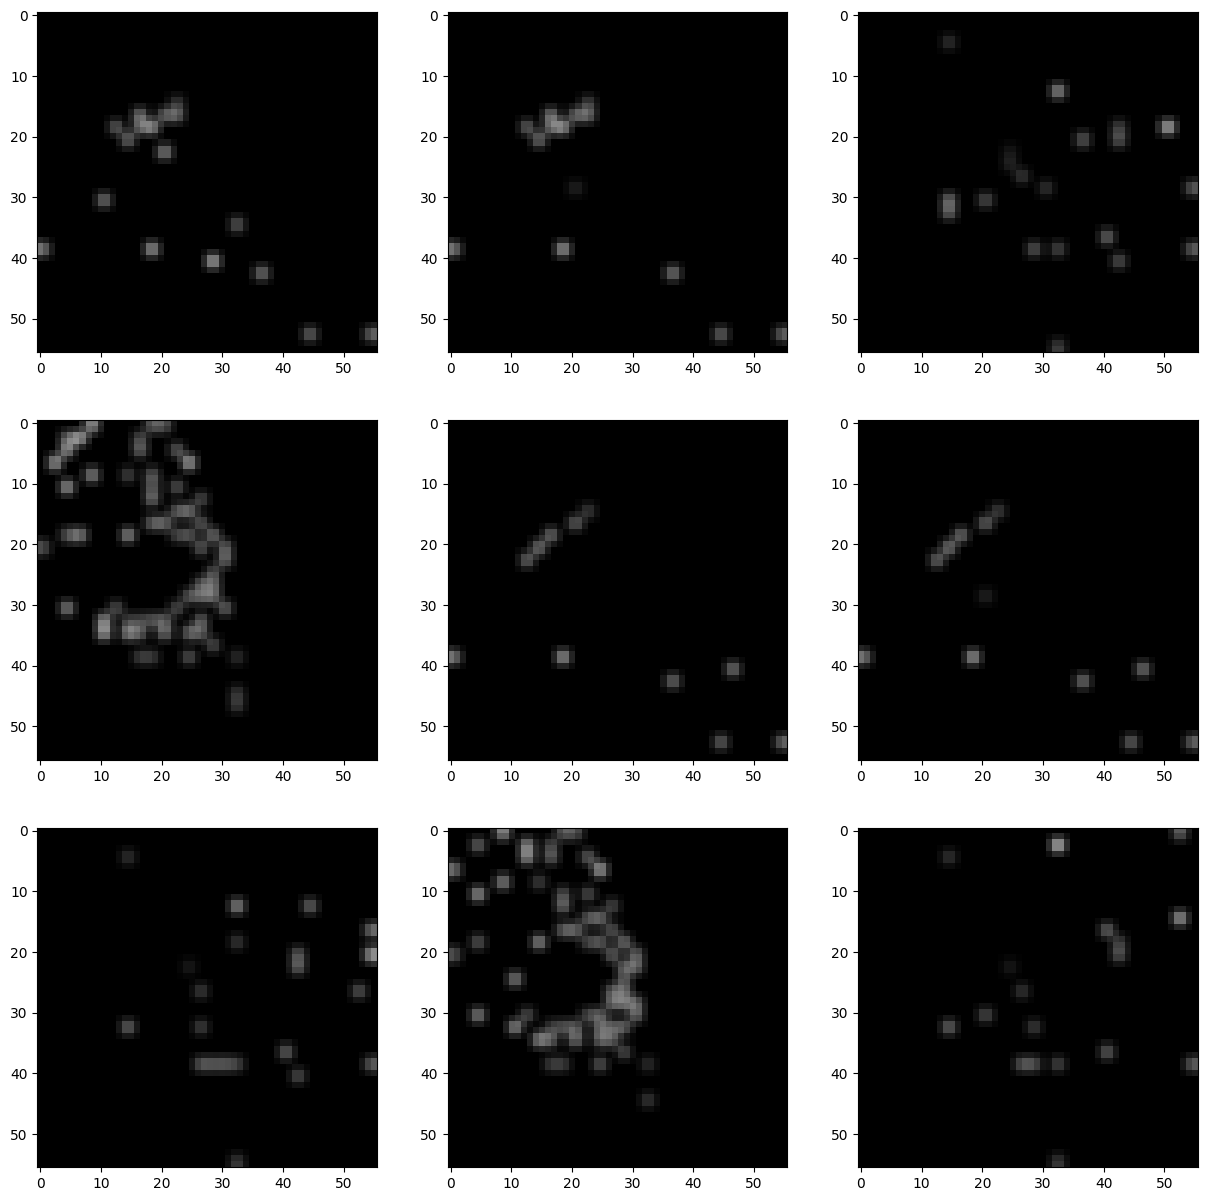

In [26]:
plt.figure(figsize=(15,15))
test_generator = BatchGenerator("./data/screw_dataset/train/wo_screw", 9)

# batch = next(test_generator)
batch = next(iter(test_generator))[0]

preds = autoencoder.predict(batch)
for i, (gt, pred) in enumerate(zip(batch, preds)):
    plt.subplot(3,3,i+1)
    
    gt = gt[..., 0]
    pred = pred[..., 0]
    error = abs(gt - pred)
    error = error > 0.17
    error = np.uint8(error * 255)
    
    pred = np.uint8(pred * 255)
    pred = cv2.bitwise_and(pred, error)
    pred = cv2.resize(pred, None, fx=2, fy=2)
    plt.imshow(cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB))
plt.show()

In [48]:
def calc_mse2(generator):
    mse2 = []
    
    for sample, _ in tqdm(generator):
        pred = autoencoder.predict(sample)
        a = pred - sample
        a = a ** 2
        a = a.sum()
        mse2.append(a)

    mse2 = np.asarray(mse2)
    return mse2.mean(), mse2.std()

true_generator2 = BatchGenerator("./data/screw_dataset/val/wo_screw", 1)
anomaly_generator2 = BatchGenerator("./data/screw_dataset/val/torx", 1)
print(calc_mse(true_generator2))
print(calc_mse(anomaly_generator2))

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 1/300 [00:00<00:34,  8.55it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 3/300 [00:00<00:24, 12.01it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 5/300 [00:00<00:22, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 7/300 [00:00<00:21, 13.80it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 9/300 [00:00<00:22, 12.92it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 11/300 [00:00<00:22, 12.92it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 13/300 [00:01<00:21, 13.23it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 15/300 [00:01<00:21, 13.32it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 17/300 [00:01<00:22, 12.52it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 19/300 [00:01<00:22, 12.69it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 21/300 [00:01<00:21, 13.01it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 23/300 [00:01<00:21, 13.16it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 25/300 [00:01<00:20, 13.51it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 27/300 [00:02<00:19, 13.91it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 29/300 [00:02<00:20, 13.18it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 31/300 [00:02<00:21, 12.75it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 33/300 [00:02<00:20, 13.07it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 35/300 [00:02<00:20, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 37/300 [00:02<00:20, 13.11it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 39/300 [00:02<00:19, 13.15it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 41/300 [00:03<00:19, 13.61it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 43/300 [00:03<00:24, 10.60it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 45/300 [00:03<00:23, 10.78it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 47/300 [00:03<00:22, 11.15it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 49/300 [00:03<00:21, 11.73it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 51/300 [00:04<00:20, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 53/300 [00:04<00:20, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 55/300 [00:04<00:19, 12.74it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 57/300 [00:04<00:18, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 59/300 [00:04<00:18, 12.96it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 61/300 [00:04<00:19, 12.51it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 63/300 [00:04<00:19, 12.44it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 65/300 [00:05<00:19, 11.75it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 67/300 [00:05<00:21, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 69/300 [00:05<00:20, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 71/300 [00:05<00:19, 11.75it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 73/300 [00:05<00:18, 12.39it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 75/300 [00:06<00:17, 12.56it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 77/300 [00:06<00:17, 12.98it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 79/300 [00:06<00:17, 12.69it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 81/300 [00:06<00:20, 10.90it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 83/300 [00:06<00:21, 10.17it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 85/300 [00:07<00:23,  9.19it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██▊       | 86/300 [00:07<00:24,  8.60it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 87/300 [00:07<00:24,  8.54it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 88/300 [00:07<00:25,  8.40it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 89/300 [00:07<00:25,  8.25it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 90/300 [00:07<00:28,  7.41it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 91/300 [00:07<00:26,  7.81it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 92/300 [00:08<00:27,  7.65it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 93/300 [00:08<00:27,  7.58it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 94/300 [00:08<00:27,  7.39it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 95/300 [00:08<00:25,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 96/300 [00:08<00:26,  7.58it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 97/300 [00:08<00:26,  7.58it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 98/300 [00:08<00:24,  8.09it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 99/300 [00:08<00:26,  7.66it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 100/300 [00:09<00:24,  8.02it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 101/300 [00:09<00:24,  8.27it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 102/300 [00:09<00:23,  8.46it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 104/300 [00:09<00:22,  8.84it/s]

1/1 [==============================] - 0s 134ms/step


 35%|███▌      | 105/300 [00:09<00:26,  7.32it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 106/300 [00:09<00:24,  7.79it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 107/300 [00:09<00:24,  8.02it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 108/300 [00:09<00:22,  8.49it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▋      | 109/300 [00:10<00:22,  8.32it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 110/300 [00:10<00:24,  7.75it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 111/300 [00:10<00:24,  7.59it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 112/300 [00:10<00:25,  7.37it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 113/300 [00:10<00:24,  7.48it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 114/300 [00:10<00:24,  7.68it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 115/300 [00:10<00:24,  7.51it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 116/300 [00:11<00:25,  7.33it/s]

1/1 [==============================] - 0s 65ms/step


 39%|███▉      | 117/300 [00:11<00:25,  7.29it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 118/300 [00:11<00:26,  6.99it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 119/300 [00:11<00:23,  7.59it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 121/300 [00:11<00:20,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 122/300 [00:11<00:19,  8.96it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 124/300 [00:11<00:17, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 126/300 [00:12<00:17, 10.00it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 128/300 [00:12<00:16, 10.30it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 130/300 [00:12<00:17,  9.96it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▎     | 131/300 [00:12<00:17,  9.64it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 132/300 [00:12<00:17,  9.52it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 134/300 [00:12<00:16, 10.24it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 136/300 [00:13<00:16,  9.89it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 138/300 [00:13<00:15, 10.43it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 140/300 [00:13<00:15, 10.51it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 142/300 [00:13<00:15, 10.18it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 144/300 [00:13<00:15, 10.12it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 146/300 [00:14<00:14, 10.68it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 148/300 [00:14<00:15, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 150/300 [00:14<00:15,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 151/300 [00:14<00:15,  9.69it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 153/300 [00:14<00:14, 10.15it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 155/300 [00:15<00:15,  9.38it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 156/300 [00:15<00:15,  9.35it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 158/300 [00:15<00:14, 10.06it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 160/300 [00:15<00:15,  8.92it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 161/300 [00:15<00:15,  8.83it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 163/300 [00:15<00:14,  9.70it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 164/300 [00:16<00:14,  9.48it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 166/300 [00:16<00:13, 10.15it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 168/300 [00:16<00:12, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 170/300 [00:16<00:13,  9.81it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 171/300 [00:16<00:13,  9.72it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 173/300 [00:16<00:12,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 174/300 [00:17<00:12,  9.83it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 176/300 [00:17<00:12, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 178/300 [00:17<00:12,  9.89it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 180/300 [00:17<00:12,  9.96it/s]

1/1 [==============================] - 0s 68ms/step


 61%|██████    | 182/300 [00:17<00:11,  9.85it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 184/300 [00:17<00:11, 10.51it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 186/300 [00:18<00:10, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 188/300 [00:18<00:10, 10.86it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 190/300 [00:18<00:11,  9.99it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 192/300 [00:18<00:10,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 194/300 [00:18<00:10, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 196/300 [00:19<00:10, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 198/300 [00:19<00:10,  9.79it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 200/300 [00:19<00:10,  9.94it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 201/300 [00:19<00:10,  9.39it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 202/300 [00:19<00:10,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 204/300 [00:20<00:09,  9.66it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▊   | 206/300 [00:20<00:09,  9.52it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 207/300 [00:20<00:09,  9.43it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 209/300 [00:20<00:09,  9.73it/s]

1/1 [==============================] - 0s 78ms/step


 70%|███████   | 210/300 [00:20<00:10,  8.78it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 211/300 [00:20<00:10,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 213/300 [00:21<00:09,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 215/300 [00:21<00:08,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 216/300 [00:21<00:08,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 217/300 [00:21<00:08,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 219/300 [00:21<00:07, 10.15it/s]

1/1 [==============================] - 0s 68ms/step


 73%|███████▎  | 220/300 [00:21<00:08,  9.35it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 222/300 [00:21<00:07,  9.94it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 223/300 [00:22<00:08,  9.58it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 225/300 [00:22<00:07,  9.88it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 227/300 [00:22<00:07, 10.34it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 229/300 [00:22<00:07,  9.61it/s]

1/1 [==============================] - 0s 133ms/step


 77%|███████▋  | 230/300 [00:22<00:08,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 231/300 [00:22<00:08,  8.47it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 232/300 [00:23<00:07,  8.61it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 234/300 [00:23<00:06,  9.60it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 236/300 [00:23<00:06,  9.69it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 238/300 [00:23<00:06, 10.26it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 240/300 [00:23<00:05, 10.14it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 242/300 [00:23<00:05, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 244/300 [00:24<00:05, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 246/300 [00:24<00:05, 10.35it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 248/300 [00:24<00:04, 10.46it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 250/300 [00:24<00:04, 10.20it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 252/300 [00:24<00:04, 10.41it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 254/300 [00:25<00:04, 10.09it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 256/300 [00:25<00:04, 10.40it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 258/300 [00:25<00:03, 10.50it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 260/300 [00:25<00:03, 10.64it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 262/300 [00:25<00:03, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 264/300 [00:26<00:03,  9.79it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 266/300 [00:26<00:03, 10.25it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 268/300 [00:26<00:03,  9.60it/s]

1/1 [==============================] - 0s 66ms/step


 90%|████████▉ | 269/300 [00:26<00:03,  8.88it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 270/300 [00:26<00:03,  8.99it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 271/300 [00:26<00:03,  8.68it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 272/300 [00:27<00:03,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 273/300 [00:27<00:03,  8.37it/s]

1/1 [==============================] - 0s 77ms/step


 91%|█████████▏| 274/300 [00:27<00:03,  7.77it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 275/300 [00:27<00:03,  7.87it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 276/300 [00:27<00:03,  7.71it/s]

1/1 [==============================] - 0s 76ms/step


 92%|█████████▏| 277/300 [00:27<00:03,  7.12it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 278/300 [00:27<00:03,  7.16it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 279/300 [00:28<00:02,  7.24it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 280/300 [00:28<00:02,  7.71it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 281/300 [00:28<00:02,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 282/300 [00:28<00:02,  8.41it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 283/300 [00:28<00:02,  8.26it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 284/300 [00:28<00:01,  8.51it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 285/300 [00:28<00:01,  7.97it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 286/300 [00:28<00:01,  8.04it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 287/300 [00:29<00:01,  8.35it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 288/300 [00:29<00:01,  8.34it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 289/300 [00:29<00:01,  8.45it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 290/300 [00:29<00:01,  8.41it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 291/300 [00:29<00:01,  8.35it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 292/300 [00:29<00:00,  8.53it/s]

1/1 [==============================] - 0s 82ms/step


 98%|█████████▊| 293/300 [00:29<00:00,  7.84it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 294/300 [00:29<00:00,  7.88it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 295/300 [00:29<00:00,  8.13it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 297/300 [00:30<00:00,  8.99it/s]

1/1 [==============================] - 0s 96ms/step


 99%|█████████▉| 298/300 [00:30<00:00,  7.74it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 299/300 [00:30<00:00,  7.84it/s]

1/1 [==============================] - 0s 44ms/step


100%|██████████| 300/300 [00:30<00:00,  9.80it/s]


(2.8854941821429376, 1.207933151967731)


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  0%|          | 1/300 [00:00<00:44,  6.71it/s]

1/1 [==============================] - 0s 62ms/step


  1%|          | 2/300 [00:00<00:40,  7.32it/s]

1/1 [==============================] - 0s 90ms/step


  1%|          | 3/300 [00:00<00:47,  6.32it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▏         | 4/300 [00:00<00:42,  7.02it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 6/300 [00:00<00:37,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 7/300 [00:00<00:37,  7.77it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 8/300 [00:01<00:36,  7.96it/s]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 9/300 [00:01<00:45,  6.40it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 11/300 [00:01<00:36,  7.98it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 12/300 [00:01<00:36,  7.99it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 14/300 [00:01<00:31,  9.15it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 16/300 [00:01<00:28, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 18/300 [00:02<00:29,  9.60it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 20/300 [00:02<00:26, 10.45it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 22/300 [00:02<00:25, 10.96it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 24/300 [00:02<00:25, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 26/300 [00:02<00:24, 11.07it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 28/300 [00:03<00:24, 10.91it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 30/300 [00:03<00:24, 10.81it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 32/300 [00:03<00:25, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 34/300 [00:03<00:26, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 36/300 [00:03<00:24, 10.70it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 38/300 [00:03<00:24, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 40/300 [00:04<00:24, 10.48it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 42/300 [00:04<00:23, 10.85it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 44/300 [00:04<00:24, 10.60it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 46/300 [00:04<00:25, 10.16it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 48/300 [00:04<00:25,  9.96it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 50/300 [00:05<00:25,  9.78it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 52/300 [00:05<00:23, 10.38it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 54/300 [00:05<00:24, 10.09it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 56/300 [00:05<00:25,  9.76it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 58/300 [00:05<00:24,  9.80it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 60/300 [00:06<00:23, 10.08it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 62/300 [00:06<00:23, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 64/300 [00:06<00:23, 10.13it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 66/300 [00:06<00:22, 10.64it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 68/300 [00:06<00:22, 10.52it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 70/300 [00:07<00:21, 10.62it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 72/300 [00:07<00:21, 10.76it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 74/300 [00:07<00:22,  9.93it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 76/300 [00:07<00:21, 10.50it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 78/300 [00:07<00:21, 10.49it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 80/300 [00:08<00:21, 10.43it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 82/300 [00:08<00:20, 10.73it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 84/300 [00:08<00:19, 10.97it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 86/300 [00:08<00:19, 10.85it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 88/300 [00:08<00:18, 11.16it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 90/300 [00:08<00:18, 11.36it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 92/300 [00:09<00:18, 11.46it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 94/300 [00:09<00:19, 10.31it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 96/300 [00:09<00:18, 10.80it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 98/300 [00:09<00:18, 10.98it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 100/300 [00:09<00:19, 10.51it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 102/300 [00:10<00:18, 10.69it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 104/300 [00:10<00:19, 10.25it/s]

1/1 [==============================] - 0s 151ms/step


 35%|███▌      | 106/300 [00:10<00:23,  8.33it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 107/300 [00:10<00:23,  8.39it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 108/300 [00:10<00:22,  8.63it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 110/300 [00:11<00:19,  9.76it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 112/300 [00:11<00:17, 10.91it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 114/300 [00:11<00:16, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 116/300 [00:11<00:14, 12.27it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 118/300 [00:11<00:14, 12.56it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 120/300 [00:11<00:13, 13.21it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 122/300 [00:11<00:12, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 124/300 [00:12<00:12, 14.11it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 126/300 [00:12<00:13, 13.20it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 128/300 [00:12<00:12, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 130/300 [00:12<00:12, 13.49it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 132/300 [00:12<00:12, 13.72it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 134/300 [00:12<00:12, 13.60it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 136/300 [00:12<00:11, 14.09it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 138/300 [00:13<00:11, 14.43it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 140/300 [00:13<00:11, 14.45it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 142/300 [00:13<00:11, 13.95it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 144/300 [00:13<00:11, 14.05it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 146/300 [00:13<00:10, 14.36it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 148/300 [00:13<00:10, 14.46it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 150/300 [00:13<00:10, 14.19it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 152/300 [00:14<00:10, 14.10it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 154/300 [00:14<00:10, 13.98it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 156/300 [00:14<00:10, 14.13it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 158/300 [00:14<00:10, 13.79it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 160/300 [00:14<00:09, 14.02it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 162/300 [00:14<00:10, 13.26it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 164/300 [00:14<00:10, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 166/300 [00:15<00:09, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 168/300 [00:15<00:09, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 170/300 [00:15<00:09, 14.38it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 172/300 [00:15<00:09, 14.20it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 174/300 [00:15<00:08, 14.16it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 176/300 [00:15<00:08, 14.51it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 178/300 [00:15<00:08, 14.35it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 180/300 [00:16<00:08, 14.42it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 182/300 [00:16<00:08, 13.99it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 184/300 [00:16<00:08, 14.05it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 186/300 [00:16<00:08, 13.14it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 188/300 [00:16<00:08, 13.17it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 190/300 [00:16<00:08, 12.29it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 192/300 [00:16<00:08, 12.24it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 194/300 [00:17<00:08, 12.16it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 196/300 [00:17<00:08, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 198/300 [00:17<00:08, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 200/300 [00:17<00:08, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 202/300 [00:17<00:07, 12.65it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 204/300 [00:17<00:07, 12.73it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▊   | 206/300 [00:18<00:07, 12.52it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 208/300 [00:18<00:07, 12.58it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 210/300 [00:18<00:07, 12.80it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 212/300 [00:18<00:06, 12.61it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 214/300 [00:18<00:06, 12.92it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 216/300 [00:18<00:06, 13.14it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 218/300 [00:19<00:06, 13.04it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 220/300 [00:19<00:06, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 222/300 [00:19<00:05, 13.19it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 224/300 [00:19<00:05, 13.80it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 226/300 [00:19<00:05, 14.27it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 228/300 [00:19<00:05, 14.19it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 230/300 [00:19<00:04, 14.53it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 232/300 [00:19<00:04, 14.81it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 234/300 [00:20<00:04, 14.52it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 236/300 [00:20<00:04, 14.32it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 238/300 [00:20<00:04, 14.25it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 240/300 [00:20<00:04, 14.54it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 242/300 [00:20<00:03, 14.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 244/300 [00:20<00:03, 14.37it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 246/300 [00:20<00:03, 14.25it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 248/300 [00:21<00:03, 14.29it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 250/300 [00:21<00:03, 14.51it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 252/300 [00:21<00:03, 14.50it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 254/300 [00:21<00:03, 14.28it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 256/300 [00:21<00:03, 14.35it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 258/300 [00:21<00:02, 14.58it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 260/300 [00:21<00:02, 14.03it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████▋ | 262/300 [00:22<00:03, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 264/300 [00:22<00:02, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 266/300 [00:22<00:02, 13.19it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 268/300 [00:22<00:02, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 270/300 [00:22<00:02, 13.61it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 272/300 [00:22<00:01, 14.06it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 274/300 [00:23<00:01, 14.34it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 276/300 [00:23<00:01, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 278/300 [00:23<00:01, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 280/300 [00:23<00:01, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 282/300 [00:23<00:01, 14.69it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 284/300 [00:23<00:01, 13.98it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 286/300 [00:23<00:01, 13.81it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 288/300 [00:24<00:00, 13.15it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 290/300 [00:24<00:00, 13.61it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 292/300 [00:24<00:00, 13.86it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 294/300 [00:24<00:00, 13.03it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 296/300 [00:24<00:00, 13.20it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 298/300 [00:24<00:00, 13.40it/s]

1/1 [==============================] - 0s 45ms/step


100%|██████████| 300/300 [00:24<00:00, 12.01it/s]

(20.877810764850906, 4.500782506588622)
